In [14]:
import pandas as pd
import matplotlib
import xgboost
from prophet import Prophet
from pathlib import Path


matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [15]:
df = pd.read_csv(Path.cwd().parent / "data" / "consumption_temp.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.set_index(["location", "time"]).sort_index()
df

consumption  temperature
location  time                                         
bergen    2022-04-07 21:00:00     1.113325         -0.3
          2022-04-07 22:00:00     1.050327          0.0
          2022-04-07 23:00:00     1.008794         -0.5
          2022-04-08 00:00:00     0.984202         -1.1
          2022-04-08 01:00:00     0.950335         -0.7
...                                    ...          ...
trondheim 2023-04-02 17:00:00     3.927136          3.6
          2023-04-02 18:00:00     4.067940          3.0
          2023-04-02 19:00:00     4.093120          1.4
          2023-04-02 20:00:00     3.990767         -2.7
          2023-04-02 21:00:00     3.749047         -3.8

[49494 rows x 2 columns]

<AxesSubplot: xlabel='time'>

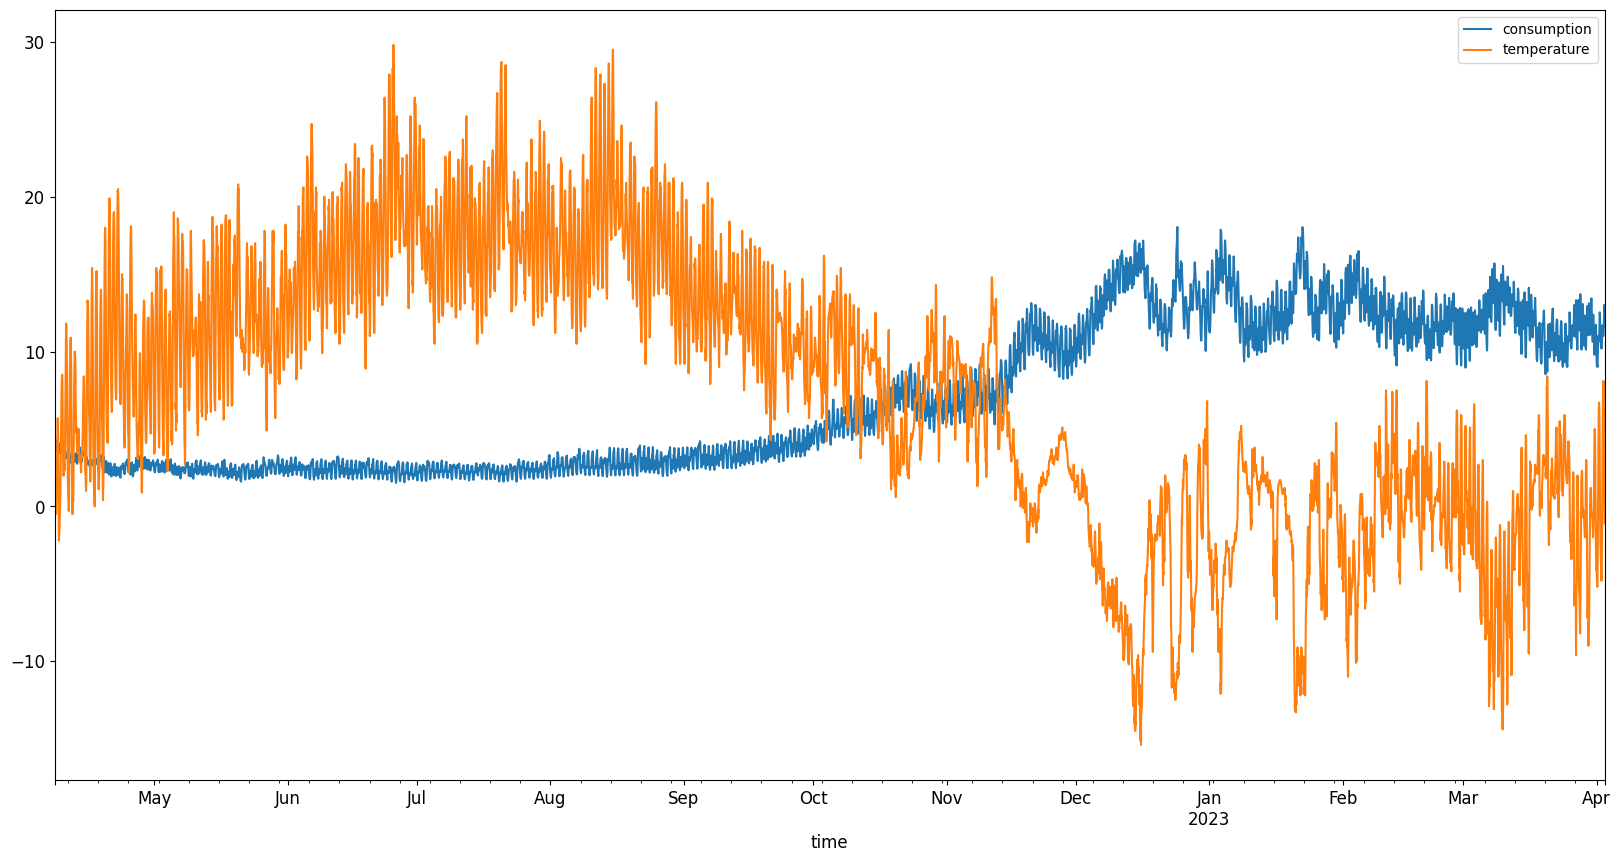

In [16]:
df.loc["oslo"].plot()

In [17]:
for city in df.index.get_level_values("location").unique().tolist():
    print(f"City: {city}")
    for y in df.columns:
        print(f"{' '*5}y: {y}")
        s = df.loc[city][y]
        mean, median, mi, ma = s.mean(), s.median(), s.min(), s.max()
        print(f"{' '*10}size: {len(s.index)}")
        print(f"{' '*10}(mean, median, min, max) = ({mean, median, mi, ma})")
    

City: bergen
     y: consumption
          size: 8641
          (mean, median, min, max) = ((1.8767155836038458, 1.3809620000000002, 0.443192, 4.650816101388889))
     y: temperature
          size: 8641
          (mean, median, min, max) = ((7.750237241258032, 8.100000381469727, -15.600000381469728, 29.299999237060547))
City: helsingfors
     y: consumption
          size: 6289
          (mean, median, min, max) = ((6.077241532835108, 6.354, 0.0, 7.86))
     y: temperature
          size: 6289
          (mean, median, min, max) = ((5.662903477534199, 3.0999999046325684, -10.100000381469728, 24.0))
City: oslo
     y: consumption
          size: 8641
          (mean, median, min, max) = ((6.876428045480846, 4.871179999999998, 1.5205599999999997, 18.045011))
     y: temperature
          size: 8641
          (mean, median, min, max) = ((7.3928827714322, 7.900000095367432, -15.399999618530272, 29.799999237060547))
City: stavanger
     y: consumption
          size: 8641
          (mean, m

<h1> Prophet </h1>

In [18]:
df_osl = df.loc["helsingfors"]
df_osl = df_osl.reset_index().rename(columns={"time": "ds", "consumption": "y"})[["ds", "y"]]
df_osl

,ds,y
0,2022-07-14 21:00:00,0.000
1,2022-07-14 22:00:00,0.000
2,2022-07-14 23:00:00,0.000
3,2022-07-15 00:00:00,0.000
4,2022-07-15 01:00:00,0.000
...,...,...
6284,2023-04-02 17:00:00,6.325
6285,2023-04-02 18:00:00,6.346
6286,2023-04-02 19:00:00,6.345
6287,2023-04-02 20:00:00,6.340


In [19]:
train_size = 5000
test_size = 1000
print(f"Train size, Test size = ({train_size}, {test_size})")
train_df = df_osl.iloc[len(df_osl.index) - train_size - test_size:len(df_osl.index) - test_size]
test_df = df_osl.iloc[len(df_osl.index) - test_size:]

train_df["y"] -= train_df["y"].mean()
train_df["y"] /= train_df["y"].std()
test_df["y"] -= test_df["y"].mean()
test_df["y"] /= test_df["y"].std()

print(len(train_df.index))
print(len(test_df.index))

Train size, Test size = (5000, 1000)
5000
1000


/var/folders/8v/8gf634jj4pg8lw4dnngfvnhw0000gn/T/ipykernel_73865/573679729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["y"] -= train_df["y"].mean()
/var/folders/8v/8gf634jj4pg8lw4dnngfvnhw0000gn/T/ipykernel_73865/573679729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["y"] /= train_df["y"].std()
/var/folders/8v/8gf634jj4pg8lw4dnngfvnhw0000gn/T/ipykernel_73865/573679729.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [20]:
model = Prophet()
model.fit(train_df)
future = pd.DataFrame()
future["ds"] = pd.date_range(test_df["ds"].min(), test_df["ds"].max(), freq="H")
forecast = model.predict(future)

18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot: xlabel='ds'>

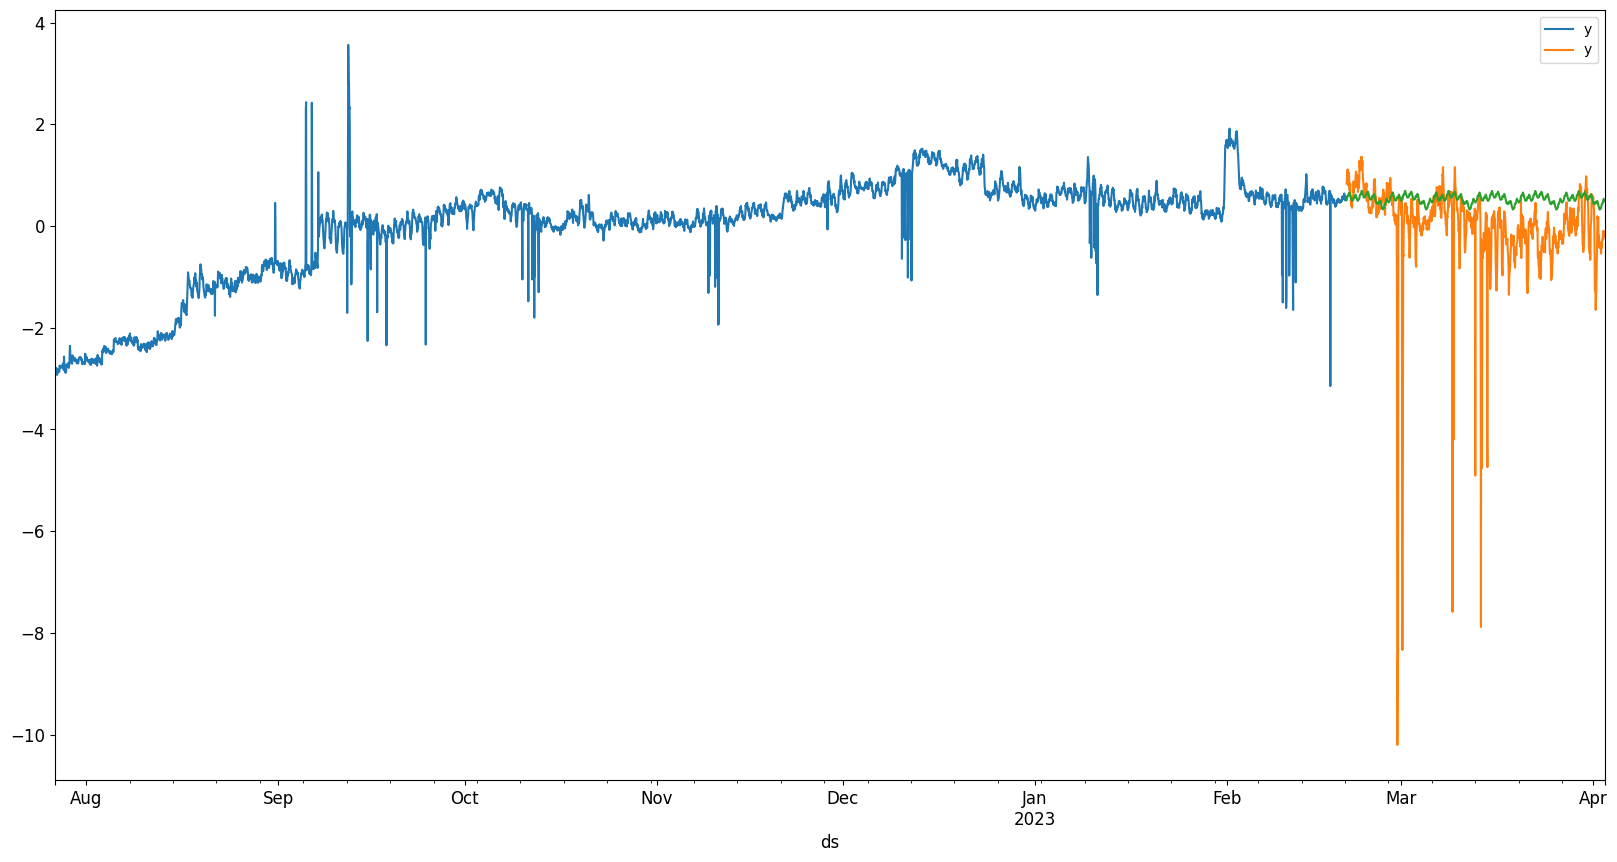

In [21]:
a = train_df.set_index("ds").plot()
test_df.set_index("ds").plot(ax=a)
forecast[["ds", "yhat"]].set_index("ds")["yhat"].plot(ax=a)

<h1> Regression </h1>

In [22]:
dfb = df.loc["bergen"]
dfb

,consumption,temperature
time,,
2022-04-07 21:00:00,1.113325,-0.3
2022-04-07 22:00:00,1.050327,0.0
2022-04-07 23:00:00,1.008794,-0.5
2022-04-08 00:00:00,0.984202,-1.1
2022-04-08 01:00:00,0.950335,-0.7
...,...,...
2023-04-02 17:00:00,3.183564,7.9
2023-04-02 18:00:00,3.401135,5.6
2023-04-02 19:00:00,3.390738,3.5


In [23]:
def featurize(df: pd.DataFrame):
    df["dayofweek"] = df.index.dayofweek
    df["dayofyear"] = df.index.dayofyear
    df["month"] = df.index.month
    df["hour"] = df.index.hour
    df["year"] = df.index.year

    return df

dfb = featurize(dfb)
dfb

,consumption,temperature,dayofweek,dayofyear,month,hour,year
time,,,,,,,
2022-04-07 21:00:00,1.113325,-0.3,3,97,4,21,2022
2022-04-07 22:00:00,1.050327,0.0,3,97,4,22,2022
2022-04-07 23:00:00,1.008794,-0.5,3,97,4,23,2022
2022-04-08 00:00:00,0.984202,-1.1,4,98,4,0,2022
2022-04-08 01:00:00,0.950335,-0.7,4,98,4,1,2022
...,...,...,...,...,...,...,...
2023-04-02 17:00:00,3.183564,7.9,6,92,4,17,2023
2023-04-02 18:00:00,3.401135,5.6,6,92,4,18,2023
2023-04-02 19:00:00,3.390738,3.5,6,92,4,19,2023


In [24]:
features = ["temperature", "dayofweek", "dayofyear", "month", "hour", "year"]
target = "consumption"

size = len(dfb.index)
train_size = 500
test_size = 6*24

train_df = dfb[size-train_size-test_size:size-test_size]
test_df = dfb[size-test_size:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [25]:
model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmse:2.70210


[100]	validation_0-rmse:1.02090
[200]	validation_0-rmse:0.41242
[300]	validation_0-rmse:0.20704
[400]	validation_0-rmse:0.14803
[500]	validation_0-rmse:0.13063
[600]	validation_0-rmse:0.12119
[700]	validation_0-rmse:0.11443
[800]	validation_0-rmse:0.11077
[900]	validation_0-rmse:0.10665
[999]	validation_0-rmse:0.10321


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

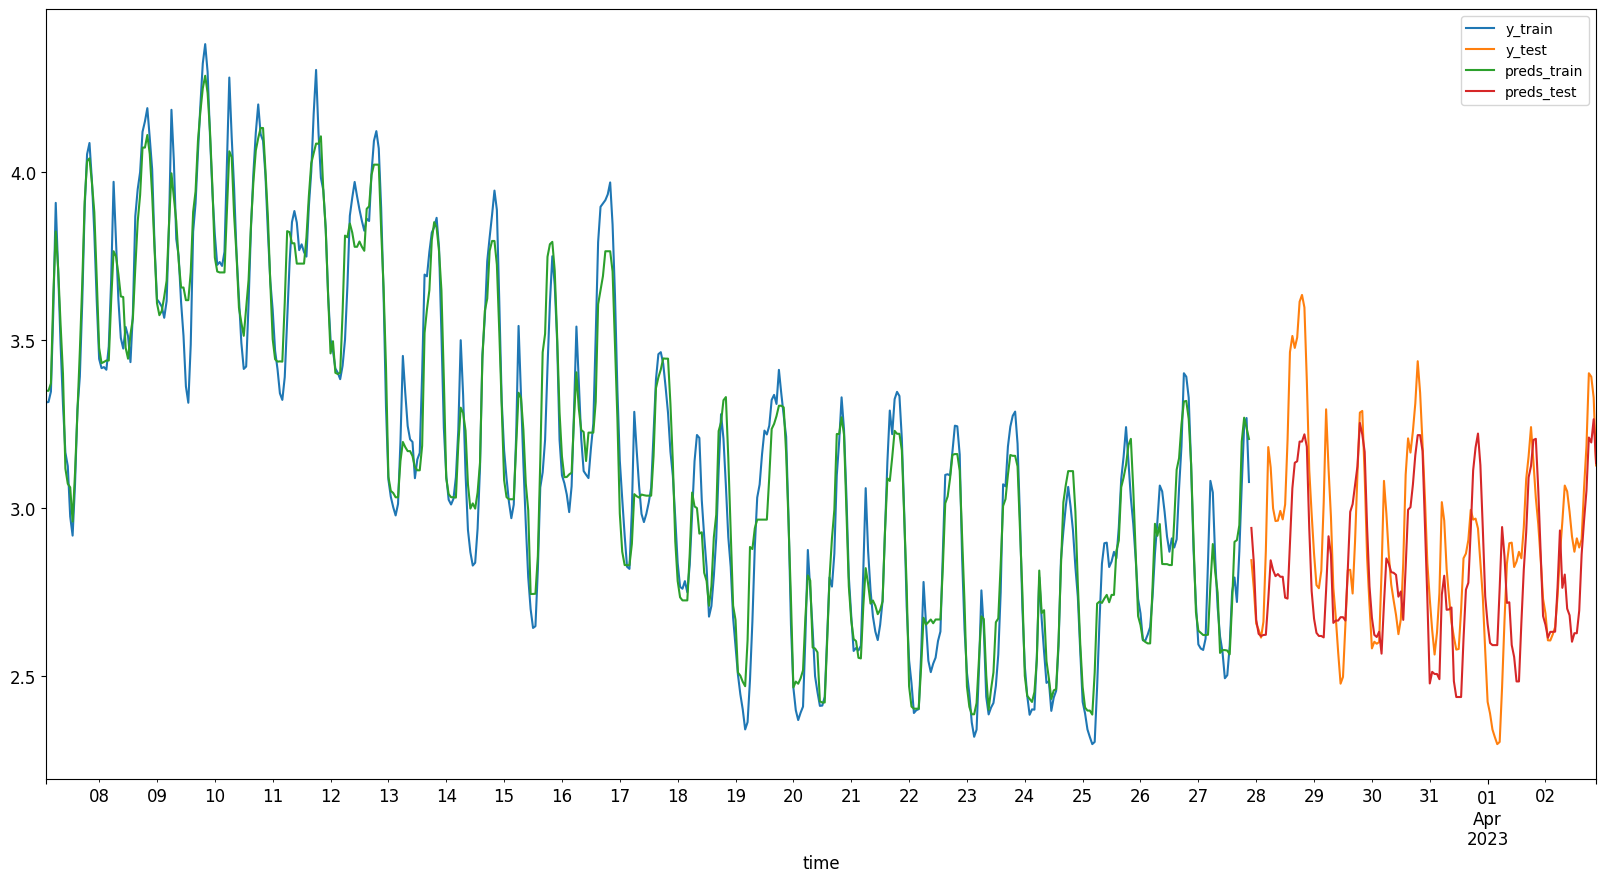

In [26]:
train_preds = pd.DataFrame(index=X_train.index, data=model.predict(X_train))
test_preds = pd.DataFrame(index=X_test.index, data=model.predict(X_test))

ax = y_train.plot()
y_test.plot(ax=ax)
train_preds.plot(ax=ax)
test_preds.plot(ax=ax)

ax.legend(["y_train", "y_test", "preds_train", "preds_test"])